Generative Adversarial Networks (GANs)
======================================
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder. If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [65]:
# install pytorch (http://pytorch.org/) and tqdm if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu118
if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm

%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

print(f"Using Pytorch {torch.__version__}.")

Using Pytorch 2.1.0+cu121.


Parameter Settings
-------------------


In [66]:
latent_dim = 50       # latent dimension
num_epochs = 100       # number of training epochs
batch_size = 100      # batch size (you may increase it to gain time, but check not to
                      # exceed your GPU memory limit)
learning_rate = 1e-3  # learning rate of the training algorithm
use_gpu = True        # use the GPU (strongly recommended for speed)
compile = False       # not well implemented on Colab (requires a personal installation with a
                      # relatively recent CUDA-compatible GPU)
img_size = 224

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images.

In [67]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

directories = [
    './drive/MyDrive/jellyfish/1',
    './drive/MyDrive/jellyfish/2',
    './drive/MyDrive/jellyfish/3',
    './drive/MyDrive/jellyfish/4',
    './drive/MyDrive/jellyfish/5',
    './drive/MyDrive/jellyfish/6',    # Add as many directories as you have
]


class CustomMultiDirectoryDataset(Dataset):
    def __init__(self, directories, transform=None):
        self.transform = transform
        self.images = []
        for directory in directories:
            for img_name in os.listdir(directory):
                if os.path.isfile(os.path.join(directory, img_name)):
                    self.images.append(os.path.join(directory, img_name))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image
consistent_size = (224, 224)
img_transform = transforms.Compose([
    transforms.Resize(consistent_size),  # Resize to a fixed size
    transforms.ToTensor(),
    # Add any other transformations you need
])
train_dataset = CustomMultiDirectoryDataset(directories=directories, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
mnist_dims = train_dataloader.dataset[0][0].shape[1:]
mnist_dim = train_dataloader.dataset[0][0].numel()
print(mnist_dims)
print(mnist_dim)

torch.Size([224])
50176


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Vanilla GAN
-----------
We define here the architecture of the different elements of the model. The init defines the different layers and the forward defines what happens when the model is called. We refer to it as the vanilla GAN as it the model in a very simple form.

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features * 2)
        self.fc4 = nn.Linear(self.fc3.out_features, 3 * img_size * img_size)
        #self.fc4 = nn.Linear(self.fc3.out_features, img_size * img_size)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
       # return x.view(-1, self.img_size, self.img_size)
        return x.view(-1, 3, self.img_size, self.img_size)

class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()
        #self.fc1 = nn.Linear(img_size * img_size, 4096)
        self.fc1 = nn.Linear(3 * img_size * img_size, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features // 2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features // 2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

We can now instantiate and load the model onto the GPU if relevant.

In [69]:
generator = Generator(latent_dim, img_size)
discriminator = Discriminator(img_size)

if compile:
  generator = torch.compile(generator)
  discriminator = torch.compile(discriminator)
  print("Using a compiled model (faster).")

if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))


Using the GPU (faster).
Number of parameters for generator: 154961152 and discriminator: 154798081


Training
--------
Be careful, the training can be relatively long, even with a GPU on Colab.

In [70]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate*1.02, betas=(0.5, 0.999))

# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training...')
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0


    for image_batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", position=0, leave=True):
        # moving the batch onto GPU if relevant
        image_batch = image_batch.to(device)

        # get dataset image and create real and fake labels for use in the loss
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), latent_dim, device=device)
        fake_image_batch = generator(latent)

        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)

        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    print(f"\tAverage loss generator vs. discrim.: {gen_loss_avg[-1]:.3} vs. {disc_loss_avg[-1]:.3}")

print("Done.")

Training...


Epoch 1: 100%|██████████| 8/8 [00:03<00:00,  2.22it/s]


	Average loss generator vs. discrim.: 2.27 vs. 5.36


Epoch 2: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


	Average loss generator vs. discrim.: 5.28 vs. 78.2


Epoch 3: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


	Average loss generator vs. discrim.: 0.228 vs. 97.5


Epoch 4: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


	Average loss generator vs. discrim.: 14.6 vs. 97.0


Epoch 5: 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 50.6


Epoch 6: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 50.0


Epoch 7: 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 50.0


Epoch 8: 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 41.6


Epoch 9: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.198


Epoch 10: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 11: 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 12: 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 13: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 14: 100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 15: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 16: 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 17: 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 18: 100%|██████████| 8/8 [00:03<00:00,  2.19it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 19: 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 20: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 21: 100%|██████████| 8/8 [00:03<00:00,  2.34it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 22: 100%|██████████| 8/8 [00:03<00:00,  2.20it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 23: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 24: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 25: 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 26: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 27: 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 28: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 29: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.125


Epoch 30: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0625


Epoch 31: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.125


Epoch 32: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.438


Epoch 33: 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.5


Epoch 34: 100%|██████████| 8/8 [00:03<00:00,  2.15it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 1.69


Epoch 35: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 2.19


Epoch 36: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 3.13


Epoch 37: 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 4.75


Epoch 38: 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 5.12


Epoch 39: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 6.66


Epoch 40: 100%|██████████| 8/8 [00:03<00:00,  2.30it/s]


	Average loss generator vs. discrim.: 99.9 vs. 6.13


Epoch 41: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 4.19


Epoch 42: 100%|██████████| 8/8 [00:03<00:00,  2.10it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 2.88


Epoch 43: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 1.31


Epoch 44: 100%|██████████| 8/8 [00:03<00:00,  2.31it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.562


Epoch 45: 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.312


Epoch 46: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.125


Epoch 47: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.188


Epoch 48: 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0


Epoch 49: 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]


	Average loss generator vs. discrim.: 1e+02 vs. 0.0625


Epoch 50:  62%|██████▎   | 5/8 [00:02<00:01,  1.97it/s]


KeyboardInterrupt: ignored

You may save the obtained weights after training.

In [55]:
torch.save(generator.state_dict(), './drive/MyDrive/GAN/my_vanilla_gan_generator1.pth')
torch.save(discriminator.state_dict(), './drive/MyDrive/GAN/my_vanilla_gan_discriminator1.pth')

If already saved, they can be loaded in the following way.

In [ ]:
# first load your model to generate instances of the generator and discriminator (but don't train it)
generator.load_state_dict(torch.load('./drive/MyDrive/GAN/pretrained/my_vanilla_gan_generator1.pth'))
discriminator.load_state_dict(torch.load('./drive/MyDrive/GAN/pretrained/my_vanilla_gan_generator1.pth'))

Training Curves
---------------

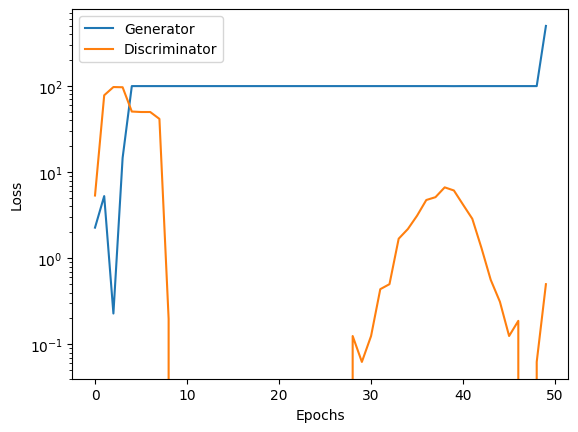

In [71]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.semilogy(gen_loss_avg, label='Generator')
plt.semilogy(disc_loss_avg, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("./drive/MyDrive/GAN/v2traingcurve3.png")
plt.show()

Interpolate in Latent Space
----------------------------

TypeError: ignored

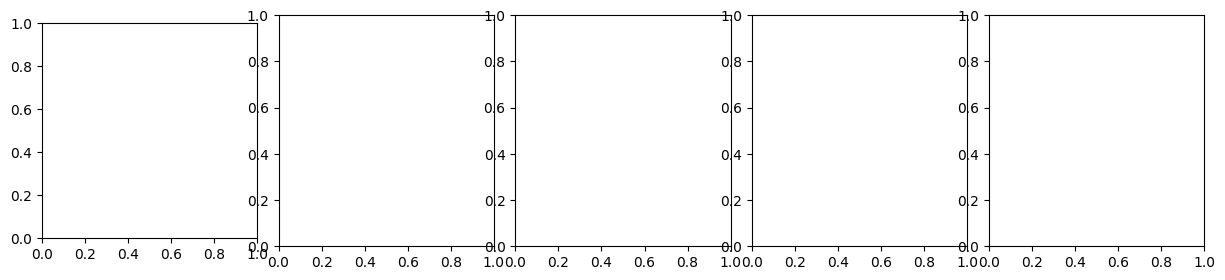

In [16]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, latent_dim, device=device)
latent_2 = torch.randn(1, latent_dim, device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    inter_image=interpolation(float(l), generator, latent_1, latent_2)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,:,:].squeeze(), cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

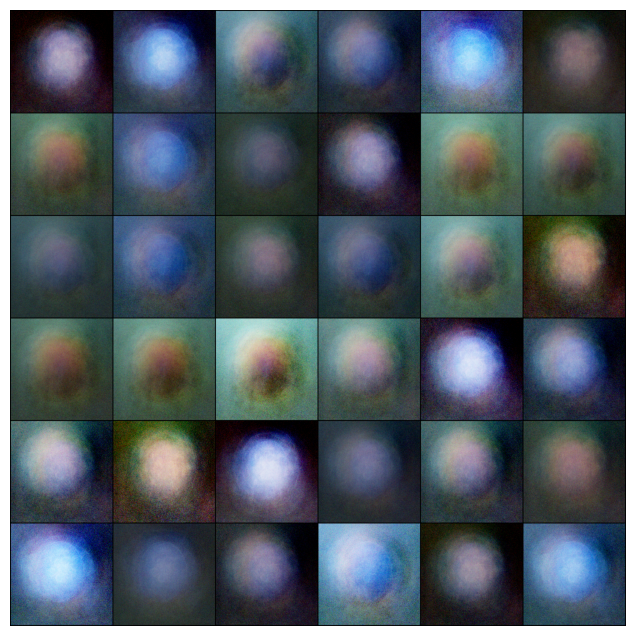

In [64]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

generator.eval()
n = 6

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn(n**2, latent_dim, device=device)
    fake_image_batch = generator(latent)
    if len(fake_image_batch.shape) == 3:
        fake_image_batch = fake_image_batch.unsqueeze(1)
    fake_image_batch = fake_image_batch.cpu()

    fig, ax = plt.subplots(figsize=(8, 8))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.savefig("./drive/MyDrive/GAN/v2generation13.png")
    plt.show()

A CNN as Backbone
-----------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters. Running this will shadow the alternative vanilla version above. You will still need to instantiate it.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

Don't hesitate to tweak the architecture to improve it.

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(latent_dim, latent_dim * 32, 5, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(latent_dim * 32)
        self.deconv2 = nn.ConvTranspose2d(latent_dim * 32, latent_dim * 16, 5, 1, 1)
        self.deconv2_bn = nn.BatchNorm2d(latent_dim * 16)
        self.deconv3 = nn.ConvTranspose2d(latent_dim * 16, latent_dim, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(latent_dim)
        self.deconv4 = nn.ConvTranspose2d(latent_dim, 1, 4, 2, 1)

    def forward(self, x):
        x = x[:, :, None, None]
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = torch.tanh(self.deconv4(x))
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, latent_dim, 4, 2, 1)
        self.conv1_bn = nn.BatchNorm2d(latent_dim)
        self.conv2 = nn.Conv2d(latent_dim, latent_dim * 16, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(latent_dim * 16)
        self.conv3 = nn.Conv2d(latent_dim * 16, latent_dim * 32, 5, 1, 1)
        self.conv3_bn = nn.BatchNorm2d(latent_dim * 32)
        self.conv4 = nn.Conv2d(latent_dim * 32, latent_dim, 5, 1, 0)
        self.conv4_bn = nn.BatchNorm2d(latent_dim)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(latent_dim, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1_bn(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.fc(self.flatten(x)))
        return x

Again, you can save and load the trained weights.

In [ ]:
torch.save(generator.state_dict(), './pretrained/my_cnn_gan_generator.pth')
torch.save(discriminator.state_dict(), './pretrained/my_cnn_gan_discriminator.pth')

In [ ]:
generator.load_state_dict(torch.load('./pretrained/my_cnn_gan_generator.pth'))
discriminator.load_state_dict(torch.load('./pretrained/cnn_gan_discriminator.pth'))

You can now have a look at the results of the model by running again the corresponding sections.